# Precipitation Frequency Table For Nested Hyetograph

__Description__: Auto-retrieve [NOAA Atlas 14](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_gis.html) precipitation statistics from [FTP](ftp://hdsc.nws.noaa.gov/pub/hdsc/data/) and calcualte the area-averaged precipitation frequency table for the area of interest (AOI).

__Input__: A vector polygon of the AOI and the durations of interest.

__Output__: A spreadsheet with sheets for each recurrence interval hyetograph shape 

---

## Load Libraries, Parameters, and Data:

### Libraries:

In [1]:
import sys
sys.path.append('../../core')
from hydromet import* #Using new hydromet_stratified
from hydromet_stratified import* #Using new hydromet_stratified

### Parameters: 

#### Papermill (site specific):

In [12]:

## Filenames and fields:
Project_Area = 'Amite'          # Project area name
Pluvial_Model = 'P01'                # Pluvial model name
BCN = '080702020804'               # Domain/boundary condition name 071200040505 Kansas 102500170609 Nevada '160600140303'
polygon = 'WA2_stpln.shp'           # Shapefile name
filter_field = 'HUC_12'          #HUC12 Attribute with in the vector polygon used for data selection
select_data = BCN                    # Value within the filter_field used for data selection


## Paths:
root_dir = pl.Path(os.getcwd())
datarepository_dir = root_dir.parent.parent/'DataRepository'
polygon_dir = root_dir/'Inputs'/polygon
outputs_dir = root_dir/'Outputs'


brute_force_projection = None

##### Convert all paths to objects:

In [7]:
datarepository_dir = pl.Path(datarepository_dir)
polygon_dir = pl.Path(polygon_dir)
outputs_dir = pl.Path(outputs_dir)
polygon_dir

WindowsPath('C:/Users/mbartlettjr/Documents/GitHub/pfra-hydromet/Notebooks/pluvial/Inputs/WA2_stpln.shp')

#### Global (project specific):

In [8]:
noaa_data_crs = 4326 #Based on newer version of GeoPandas

durations = ['05m' , '10m' ,  '15m' , '30m' ,'60m'  ,'02h' , '03h' ,'06h', '12h','24h'] #'05m' , '10m' ,  '15m' , '30m' ,'60m'  ,'02h' , '03h' ,'06h', '12h' ,'04d'
dur_names = ['5min','10min', '15min','30min','60min','2hr' , '3hr' ,'6hr', '12hr','24hr']  # '5min','10min', '15min','30min','60min','2hr' , '3hr' ,'6hr', '12hr',  '96hr'

vol_code_filename = 'NOAA_Atlas_Volume_Codes.json'
Temporal_area_filename = 'NOAA_Temporal_Areas_US.geojson'

verbose = True

## Read Vector Polygon:

### Load as a geodataframe:

In [9]:
gdf = gpd.read_file(polygon_dir)
check_attributes(gdf)

gdf.head(1)

,OBJECTID,Gaz_ID,Area_Acres,Area_SqKm,States,LoadDate,HUC_12,HU_12_Name,HU_12_Type,HU_12_Mod,...,Shape_STAr,Shape_STLe,Shape_Leng,Shape_Area,Work_Area,Engineer,Area_sqmi,Area_ac,Area_sqft,geometry
0,63992,0,37742.14707,152.737661,LA,2012-06-11,080702020804,Bayou Fountain-Bayou Manchac,S,"DD,LE,ID,UA",...,0.01433,0.96154,0.96154,0.01433,WA2,Brian,168.795155,108028.898959,4.705720e+09,"POLYGON ((3709575.006 -8591.999, 3709861.122 -..."


### Determine projection:
- If a projection cannot be determined automatically, search for the projection using the EPSG number on the following website: https://www.spatialreference.org/, select 'Proj4', and copy and paste the string above, setting it equal to brute_force_projection. Rerun the cell with the brute_force_projection string and the cell below.

In [10]:
print('Original Coordinate Reference System:', gdf.crs)
with fiona.collection(polygon_dir, 'r') as layer:
    try:
        vector_crs_prj = Proj(layer.crs).srs
        if 'epsg' in vector_crs_prj: 
            raise KeyboardInterrupt
        else: 
            print('Vector Layer crs = {}'.format(vector_crs_prj))
        
    except:
        assert brute_force_projection!= None, 'Need to specify projection'
        vector_crs_prj = brute_force_projection
        print('Error: Setting projection as {}'.format(brute_force_projection))
        
vector_crs_prj =gdf.crs

Original Coordinate Reference System: epsg:3451
Vector Layer crs = +proj=lcc +lat_0=30.5 +lon_0=-92.5 +lat_1=32.6666666666667 +lat_2=31.1666666666667 +x_0=999999.999989839 +y_0=0 +datum=NAD83 +units=us-ft +no_defs


C:\Users\mbartlettjr\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Extract the area of interest, reproject, and plot:

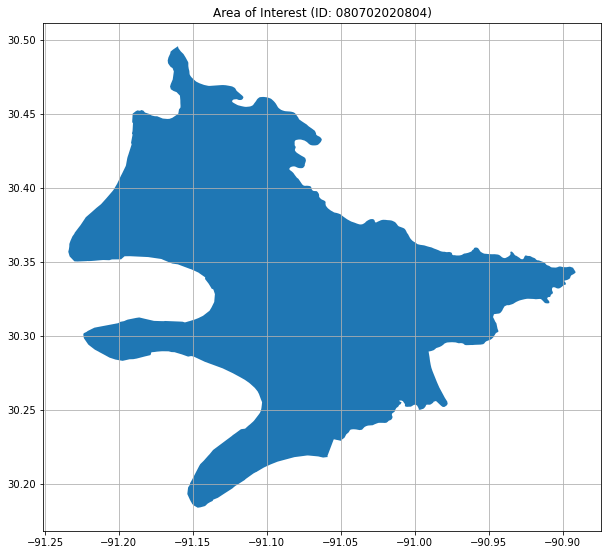

In [13]:
gdf1 = gdf.loc[gdf[filter_field] == select_data].copy()

gdf1.crs = vector_crs_prj
    
geo_df = gdf1.to_crs(epsg = noaa_data_crs)

plot_area_of_interest(geo_df, select_data, filter_field)

## Identify the NOAA Atlas 14 Volume Code:

### Determine the volume and region numbers:

Volume           9
Region           1
Percent_area     50.0
Volume_1         8
Region_1         4
Percent_area_1   50.0


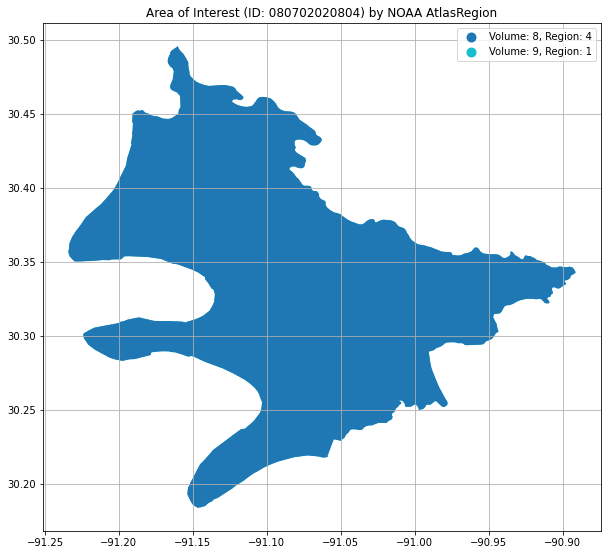

In [14]:
volume_dict, intersection_gdf = intersect_temporal_areas(geo_df, datarepository_dir, Temporal_area_filename, alldata=True)

plot_aoi_noaa_intersection(intersection_gdf, select_data)

volume = volume_dict['Volume']

### Load Atlas 14 volume code from json:

In [15]:
vol_code = get_volume_code(datarepository_dir, vol_code_filename, volume)

NOAA Atlas 14 Volume Code: se


## Retrieve the Precipitation Frequency Data:

### Get list of zip files:

In [16]:
noaa_url = 'https://hdsc.nws.noaa.gov/pub/hdsc/data/{}/'.format(vol_code)

req = urllib.request.Request(noaa_url)
data = urllib.request.urlopen(req).read().decode().split()

copy_zips = []
for duration in durations:
    zips = [d for d in data if ('.zip' in d) and ('{}'.format(duration) in d) and ('ams' not in d) and ('l.zip' not in d) and ('u.zip' not in d)]
    copy_zips.append(zips)
    if verbose: print('{} files found for {}'.format(len(zips), duration))

all_zips_list = list(np.array(copy_zips).flat)

#Added by Mark Bartlett 
#Parse out the file name by using split functions
for i, zip_name in enumerate(all_zips_list):
    all_zips_list[i]= zip_name.split("\"", 1)[1].split("\"", 1)[0]

10 files found for 05m
10 files found for 10m
10 files found for 15m
10 files found for 30m
10 files found for 60m
10 files found for 02h
10 files found for 03h
10 files found for 06h
10 files found for 12h
10 files found for 24h


### Iterate through zip files and build a table:

In [17]:
df = build_precip_table(geo_df, all_zips_list, noaa_url, vol_code, 10, verbose) #The integer is the number of times to attempt getting the file from ftp

0 se1yr05ma.zip
1 se2yr05ma.zip
2 se5yr05ma.zip
3 se10yr05ma.zip
4 se25yr05ma.zip
5 se50yr05ma.zip
6 se100yr05ma.zip
7 se200yr05ma.zip
8 se500yr05ma.zip
9 se1000yr05ma.zip
10 se1yr10ma.zip
11 se2yr10ma.zip
12 se5yr10ma.zip
13 se10yr10ma.zip
14 se25yr10ma.zip
15 se50yr10ma.zip
16 se100yr10ma.zip
17 se200yr10ma.zip
18 se500yr10ma.zip
19 se1000yr10ma.zip
20 se1yr15ma.zip
21 se2yr15ma.zip
22 se5yr15ma.zip
23 se10yr15ma.zip
24 se25yr15ma.zip
25 se50yr15ma.zip
26 se100yr15ma.zip
27 se200yr15ma.zip
28 se500yr15ma.zip
29 se1000yr15ma.zip
30 se1yr30ma.zip
31 se2yr30ma.zip
32 se5yr30ma.zip
33 se10yr30ma.zip
34 se25yr30ma.zip
35 se50yr30ma.zip
36 se100yr30ma.zip
37 se200yr30ma.zip
38 se500yr30ma.zip
39 se1000yr30ma.zip
40 se1yr60ma.zip
41 se2yr60ma.zip
42 se5yr60ma.zip
43 se10yr60ma.zip
44 se25yr60ma.zip
45 se50yr60ma.zip
46 se100yr60ma.zip
47 se200yr60ma.zip
48 se500yr60ma.zip
49 se1000yr60ma.zip
50 se1yr02ha.zip
51 se2yr02ha.zip
52 se5yr02ha.zip
53 se10yr02ha.zip
54 se25yr02ha.zip
55 se50yr02ha

,region,TR,duration,statistic,value
0,se,1,05m,Expected Value,0.528372
1,se,2,05m,Expected Value,0.602769
2,se,5,05m,Expected Value,0.725998
3,se,10,05m,Expected Value,0.829749
4,se,25,05m,Expected Value,0.974771


None


## Save the Results to an Excel Workbook:

### Create an outputs directory:

In [18]:
if not os.path.isdir(outputs_dir):
    os.mkdir(outputs_dir)

### Save:

---

## Calculate NRCS nested hyetograph function 

In [19]:
c_df = df[df['statistic'] =='Expected Value'].set_index('TR')
hyetos = {}
for evnt in c_df.index.astype(str).tolist()[1:10]:
    precip_df = c_df.loc[evnt][['duration','value']].set_index('duration')
    hyetos[evnt] = precip_hyetograph_nrcs(precip_df)   

#### Plot to check

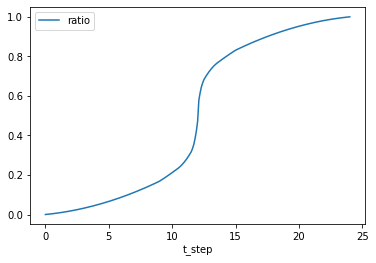

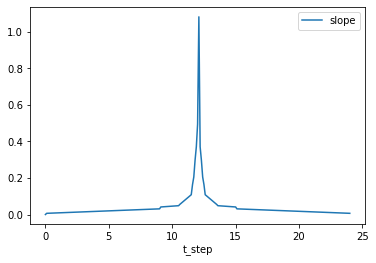

In [20]:
hyetos['100'].plot('t_step','ratio')
hyetos['100'].plot('t_step','slope')

## Save:

In [29]:
c_df

,region,duration,statistic,value
TR,,,,
1,se,05m,Expected Value,0.528372
2,se,05m,Expected Value,0.602769
5,se,05m,Expected Value,0.725998
10,se,05m,Expected Value,0.829749
25,se,05m,Expected Value,0.974771
...,...,...,...,...
50,se,24h,Expected Value,10.616287
100,se,24h,Expected Value,12.159239
200,se,24h,Expected Value,13.823333


In [31]:
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}__nrcs_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN))

events_hyeto = c_df.index.astype(str).tolist()[1:10]

for i, d in enumerate(events_hyeto):
    table = hyetos[d][['ratio','slope']]
    hyetos[d].to_excel(writer, sheet_name = 'nrcs_hye_{}'.format(events_hyeto[i]))
    print(table)
    
writer.save()

         ratio     slope
time                    
0.0   0.000000  0.000000
0.1   0.000454  0.004535
0.2   0.000928  0.004748
0.3   0.001424  0.004960
0.4   0.001941  0.005172
...        ...       ...
23.6  0.998059  0.005384
23.7  0.998576  0.005172
23.8  0.999072  0.004960
23.9  0.999546  0.004748
24.0  1.000000  0.004535

[241 rows x 2 columns]
         ratio     slope
time                    
0.0   0.000000  0.000000
0.1   0.000536  0.005361
0.2   0.001094  0.005583
0.3   0.001675  0.005806
0.4   0.002278  0.006028
...        ...       ...
23.6  0.997722  0.006251
23.7  0.998325  0.006028
23.8  0.998906  0.005806
23.9  0.999464  0.005583
24.0  1.000000  0.005361

[241 rows x 2 columns]
         ratio     slope
time                    
0.0   0.000000  0.000000
0.1   0.000581  0.005808
0.2   0.001185  0.006041
0.3   0.001812  0.006274
0.4   0.002463  0.006508
...        ...       ...
23.6  0.997537  0.006741
23.7  0.998188  0.006508
23.8  0.998815  0.006274
23.9  0.999419  0.006041
24

---

# End